In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
from scipy.stats import beta
import matplotlib
import pandas as pd
from models import BetaBernoulli

matplotlib.rcParams['font.size'] = 8
matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['text.usetex'] = False

num_samples = 1000

from models import BetaBernoulli, SumOfBetaEce
from data_utils import datafile_dict, datasize_dict, num_classes_dict
from active_utils import prepare_data

In [2]:
datafile = datafile_dict['cifar100']
categories, observations, confidences, idx2category, category2idx = prepare_data(datafile, False)

df = pd.read_csv("../data/cifar100/predictions.txt", sep='\s') 
id2class = dict(enumerate(set(df['Correct'])))
class2id = {id2class[k]: k for k in id2class}
print(id2class)

Accuracy: 0.741
{0: 'woman', 1: 'kangaroo', 2: 'raccoon', 3: 'man', 4: 'motorcycle', 5: 'squirrel', 6: 'spider', 7: 'cockroach', 8: 'pickup_truck', 9: 'poppy', 10: 'sunflower', 11: 'ray', 12: 'wardrobe', 13: 'wolf', 14: 'flatfish', 15: 'whale', 16: 'dolphin', 17: 'pear', 18: 'chimpanzee', 19: 'bus', 20: 'crab', 21: 'beaver', 22: 'bottle', 23: 'otter', 24: 'elephant', 25: 'maple_tree', 26: 'lobster', 27: 'plain', 28: 'snake', 29: 'cattle', 30: 'bear', 31: 'apple', 32: 'bee', 33: 'caterpillar', 34: 'oak_tree', 35: 'crocodile', 36: 'mountain', 37: 'hamster', 38: 'rose', 39: 'dinosaur', 40: 'sweet_pepper', 41: 'keyboard', 42: 'baby', 43: 'porcupine', 44: 'boy', 45: 'possum', 46: 'bed', 47: 'plate', 48: 'pine_tree', 49: 'skyscraper', 50: 'telephone', 51: 'train', 52: 'lamp', 53: 'cup', 54: 'television', 55: 'lawn_mower', 56: 'table', 57: 'butterfly', 58: 'fox', 59: 'leopard', 60: 'palm_tree', 61: 'road', 62: 'tiger', 63: 'castle', 64: 'can', 65: 'clock', 66: 'skunk', 67: 'chair', 68: 'rabbi

/Users/disiji/Dropbox/current/bayesian-blackbox/.venv/lib/python3.7/site-packages/ipykernel_launcher.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  after removing the cwd from sys.path.


In [3]:
# accuracy models
accuracy_model = copy.deepcopy(BetaBernoulli(k=100, prior=None))
accuracy_model.update_batch(categories, observations)

# ece models for each class
ece_models = [copy.deepcopy(SumOfBetaEce(num_bins=10, weight=None, prior_alpha=None, prior_beta=None)) for i in range(100)]
for class_idx in range(100):
    mask_idx = [i for i in range(len(observations)) if categories[i] == class_idx]
    observations_sublist = [observations[i] for i in mask_idx]
    confidences_sublist = [confidences[i] for i in mask_idx]
    ece_models[class_idx].update_batch(confidences_sublist, observations_sublist)

In [4]:
# draw samples from posterior of classwise accuracy
accuracy_samples = accuracy_model.sample(num_samples) # (num_categories, num_samples)
ece_samples = np.array([ece_models[class_idx].sample(num_samples) for class_idx in range(100)]).squeeze() # (num_categories, num_samples)

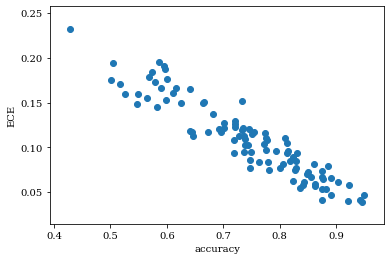

In [5]:
# plot
plt.scatter(np.mean(accuracy_samples, axis=1), np.mean(ece_samples, axis=1))
plt.xlabel('accuracy')
plt.ylabel('ECE')
plt.show()

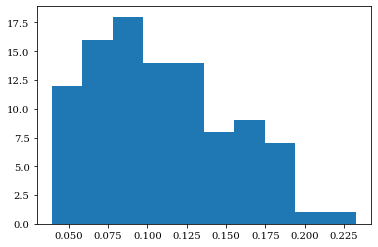

In [6]:
plt.hist(np.mean(ece_samples, axis=1));
plt.show()

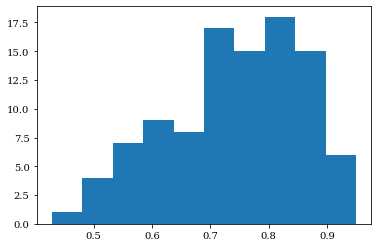

In [7]:
plt.hist(np.mean(accuracy_samples, axis=1));
plt.show()